# mouse analysis - preprocessing

In [75]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys


def MovePlots(plotpattern, subplotdir):
    os.system('mkdir -p '+str(sc.settings.figdir)+'/'+subplotdir)
    os.system('mv '+str(sc.settings.figdir)+'/*'+plotpattern+'** '+str(sc.settings.figdir)+'/'+subplotdir)


sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = './figures/preprocessing/'
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable

-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.2
anndata             0.7.5
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
brotli              NA
cairo               1.20.0
certifi             2020.12.05
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.03.1
dateutil            2.8.1
decorator           4.4.2
fsspec              0.8.7
get_version         2.1
google              NA
h5py                3.1.0
idna                2.10
igraph              0.9.6
ipykernel           5.5.0
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_server      1.4.1
jupyterlab_server   2.3.0
kiwisolver          1.3.1


'/opt/conda/bin/python'

## Import data
Import sample metadata

In [76]:
data_dir = '/nfs/users/nfs_l/lg18/team292/lg18/gonads/data/scRNAseq/mouse/'
meta = pd.read_csv(data_dir+'/meta.csv',index_col=0)
meta['stage'] = meta['stage'].astype('str')
plotmeta = list(meta.columns)
plotmeta.append('sample')
print('Number of samples: ', meta.index.size)

Number of samples:  12


In [77]:
meta

stage     sex     location
sample                                     
HCA_Mou_10827181  12.5    male        gonad
HCA_Mou_10827182  12.5    male  mesonephros
HCA_Mou_10828699  12.5  female        gonad
HCA_Mou_10828700  12.5  female  mesonephros
HCA_Mou_10827183  11.5    male        gonad
HCA_Mou_10827184  11.5    male  mesonephros
HCA_Mou_10828701  11.5  female        gonad
HCA_Mou_10828702  11.5  female  mesonephros
HCA_Mou_10827185  10.5    male        gonad
HCA_Mou_10827186  10.5    male  mesonephros
HCA_Mou_10828703  10.5  female        gonad
HCA_Mou_10828704  10.5  female  mesonephros

## Preprocessing
### Load 10x 

Filter: 1) cells (< 10 genes); 2) genes (< 3 cells) 

Quantify: 1) % mitochondrial genes; 2) total counts


In [78]:
holder = []
for sample in meta.index:
    print(sample)
    # Load 10x data as AnnData
    holder.append(sc.read_10x_mtx(data_dir+'/'+sample+'/filtered_feature_bc_matrix/',cache=True)) 
    # Set names of observation as sample + _ + barcode/probe
    holder[-1].obs_names = [sample+'_'+i.split('-')[0] for i in holder[-1].obs_names]
    # Filer genes expressed in less than 3 cells
    sc.pp.filter_genes(holder[-1], min_cells=3)
    # Filer cells with less than 10 genes expressed
    sc.pp.filter_cells(holder[-1], min_genes=150)
    # add in metadata
    holder[-1].obs['sample'] = sample
    for val in meta.columns:
        holder[-1].obs[val] = meta[val][sample]
    # Extract mitochondial genes
    mito_genes = [name for name in holder[-1].var_names if name.startswith('mt-')]
    #for each cell compute fraction of counts in mito genes vs. all genes
    #the `.A1` is only necessary, as X is sparse - it transform to a dense array after summing
    holder[-1].obs['percent_mito'] = np.sum(
        holder[-1][:, mito_genes].X, axis=1).A1 / np.sum(holder[-1].X, axis=1).A1
    #add the total counts per cell as observations-annotation to adata
    holder[-1].obs['n_counts'] = holder[-1].X.sum(axis=1).A1
    print('Total number of cells: {:d}'.format(holder[-1].n_obs))
    print('Total number of genes: {:d}'.format(holder[-1].n_vars))

... reading from cache file cache/nfs-users-nfs_l-lg18-team292-lg18-gonads-data-scRNAseq-mouse-HCA_Mou_10827181-filtered_feature_bc_matrix-matrix.h5ad


HCA_Mou_10827181


filtered out 10940 genes that are detected in less than 3 cells
filtered out 21 cells that have less than 150 genes expressed
... reading from cache file cache/nfs-users-nfs_l-lg18-team292-lg18-gonads-data-scRNAseq-mouse-HCA_Mou_10827182-filtered_feature_bc_matrix-matrix.h5ad


Total number of cells: 6243
Total number of genes: 21345
HCA_Mou_10827182


filtered out 12021 genes that are detected in less than 3 cells
filtered out 2 cells that have less than 150 genes expressed
... reading from cache file cache/nfs-users-nfs_l-lg18-team292-lg18-gonads-data-scRNAseq-mouse-HCA_Mou_10828699-filtered_feature_bc_matrix-matrix.h5ad


Total number of cells: 5907
Total number of genes: 20264
HCA_Mou_10828699


filtered out 10682 genes that are detected in less than 3 cells
filtered out 8 cells that have less than 150 genes expressed
... reading from cache file cache/nfs-users-nfs_l-lg18-team292-lg18-gonads-data-scRNAseq-mouse-HCA_Mou_10828700-filtered_feature_bc_matrix-matrix.h5ad


Total number of cells: 5992
Total number of genes: 21603
HCA_Mou_10828700


filtered out 12167 genes that are detected in less than 3 cells
filtered out 10 cells that have less than 150 genes expressed
... reading from cache file cache/nfs-users-nfs_l-lg18-team292-lg18-gonads-data-scRNAseq-mouse-HCA_Mou_10827183-filtered_feature_bc_matrix-matrix.h5ad


Total number of cells: 3104
Total number of genes: 20118
HCA_Mou_10827183


filtered out 10628 genes that are detected in less than 3 cells
filtered out 3 cells that have less than 150 genes expressed
... reading from cache file cache/nfs-users-nfs_l-lg18-team292-lg18-gonads-data-scRNAseq-mouse-HCA_Mou_10827184-filtered_feature_bc_matrix-matrix.h5ad


Total number of cells: 6989
Total number of genes: 21657
HCA_Mou_10827184


filtered out 10741 genes that are detected in less than 3 cells
... reading from cache file cache/nfs-users-nfs_l-lg18-team292-lg18-gonads-data-scRNAseq-mouse-HCA_Mou_10828701-filtered_feature_bc_matrix-matrix.h5ad


Total number of cells: 6301
Total number of genes: 21544
HCA_Mou_10828701


filtered out 10348 genes that are detected in less than 3 cells
filtered out 13 cells that have less than 150 genes expressed
... reading from cache file cache/nfs-users-nfs_l-lg18-team292-lg18-gonads-data-scRNAseq-mouse-HCA_Mou_10828702-filtered_feature_bc_matrix-matrix.h5ad


Total number of cells: 7847
Total number of genes: 21937
HCA_Mou_10828702


filtered out 10793 genes that are detected in less than 3 cells
filtered out 8 cells that have less than 150 genes expressed
... reading from cache file cache/nfs-users-nfs_l-lg18-team292-lg18-gonads-data-scRNAseq-mouse-HCA_Mou_10827185-filtered_feature_bc_matrix-matrix.h5ad


Total number of cells: 9442
Total number of genes: 21492
HCA_Mou_10827185


filtered out 11063 genes that are detected in less than 3 cells
filtered out 1 cells that have less than 150 genes expressed
... reading from cache file cache/nfs-users-nfs_l-lg18-team292-lg18-gonads-data-scRNAseq-mouse-HCA_Mou_10827186-filtered_feature_bc_matrix-matrix.h5ad


Total number of cells: 7627
Total number of genes: 21222
HCA_Mou_10827186


filtered out 11104 genes that are detected in less than 3 cells
filtered out 83 cells that have less than 150 genes expressed
... reading from cache file cache/nfs-users-nfs_l-lg18-team292-lg18-gonads-data-scRNAseq-mouse-HCA_Mou_10828703-filtered_feature_bc_matrix-matrix.h5ad


Total number of cells: 6589
Total number of genes: 21181
HCA_Mou_10828703


filtered out 11234 genes that are detected in less than 3 cells
filtered out 64 cells that have less than 150 genes expressed
... reading from cache file cache/nfs-users-nfs_l-lg18-team292-lg18-gonads-data-scRNAseq-mouse-HCA_Mou_10828704-filtered_feature_bc_matrix-matrix.h5ad


Total number of cells: 5275
Total number of genes: 21051
HCA_Mou_10828704


filtered out 12436 genes that are detected in less than 3 cells
filtered out 13 cells that have less than 150 genes expressed


Total number of cells: 6231
Total number of genes: 19849


In [79]:
# confirm N samples
print(len(holder))
# merge datasets
adata = holder[0].concatenate(holder[1:],join='outer',index_unique=None)
# copy of this matrix in Compressed Sparse Row format
adata.X = adata.X.tocsr()
adata

12


AnnData object with n_obs × n_vars = 77547 × 24520
    obs: 'n_genes', 'sample', 'stage', 'sex', 'location', 'percent_mito', 'n_counts', 'batch'
    var: 'gene_ids-0', 'feature_types-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'n_cells-11', 'gene_ids-2', 'feature_types-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'n_cells-6', 'gene_ids-7', 'feature_types-7', 'n_cells-7', 'gene_ids-8', 'feature_types-8', 'n_cells-8', 'gene_ids-9', 'feature_types-9', 'n_cells-9'

### QC pplots

Plot distributions of the values n_genes, n_counts and percent_mito

... storing 'sample' as categorical
... storing 'stage' as categorical
... storing 'sex' as categorical
... storing 'location' as categorical
... storing 'gene_ids-0' as categorical
... storing 'feature_types-0' as categorical
... storing 'gene_ids-1' as categorical
... storing 'feature_types-1' as categorical
... storing 'gene_ids-10' as categorical
... storing 'feature_types-10' as categorical
... storing 'gene_ids-11' as categorical
... storing 'feature_types-11' as categorical
... storing 'gene_ids-2' as categorical
... storing 'feature_types-2' as categorical
... storing 'gene_ids-3' as categorical
... storing 'feature_types-3' as categorical
... storing 'gene_ids-4' as categorical
... storing 'feature_types-4' as categorical
... storing 'gene_ids-5' as categorical
... storing 'feature_types-5' as categorical
... storing 'gene_ids-6' as categorical
... storing 'feature_types-6' as categorical
... storing 'gene_ids-7' as categorical
... storing 'feature_types-7' as categorical
... 

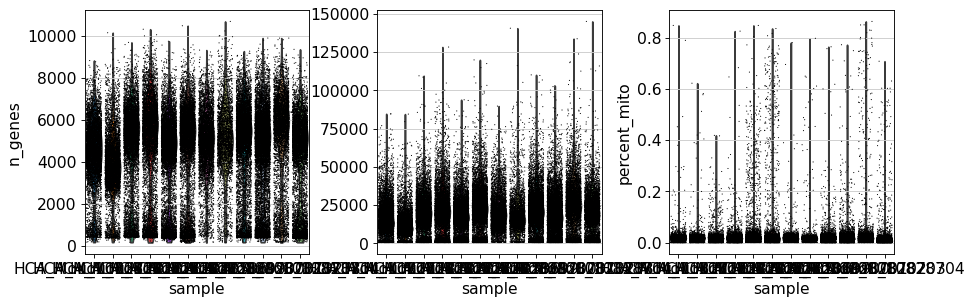

In [80]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], groupby='sample',jitter=0.4, multi_panel=True)

In [81]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],jitter=0.4, multi_panel=True, save='.pdf', show=False)
sc.pl.scatter(adata, x='n_counts', y='percent_mito', save='_numi_vs_mito.pdf', show=False)
sc.pl.scatter(adata, x='n_counts', y='n_genes', save='_numi_vs_ngenes.pdf', show=False)

In [82]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], groupby='location', rotation = 90, jitter=0.4, save='_location.pdf', show=False)
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], groupby='sex', rotation = 90, jitter=0.4, save='_sex.pdf', show=False)
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], groupby='stage', rotation = 90, jitter=0.4, save='_stage.pdf', show=False)

In [83]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
pd.DataFrame(adata.obs).to_csv(str(sc.settings.figdir)+'/metadata_prefilters.csv')

Total number of cells: 77547
Total number of genes: 24520


### Sex specific genes

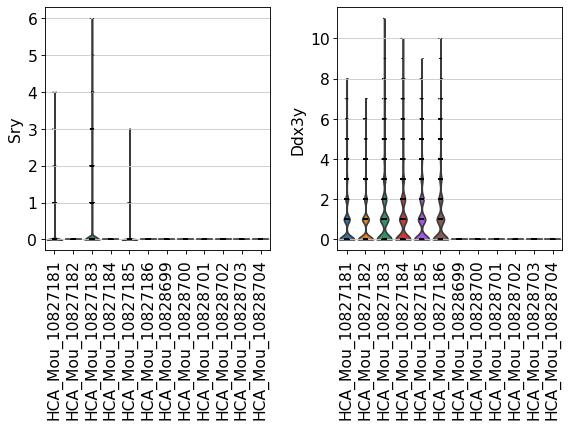

In [84]:
sc.pl.violin(adata, ['Sry', 'Ddx3y'], groupby='sample', rotation = 90) # MALE

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


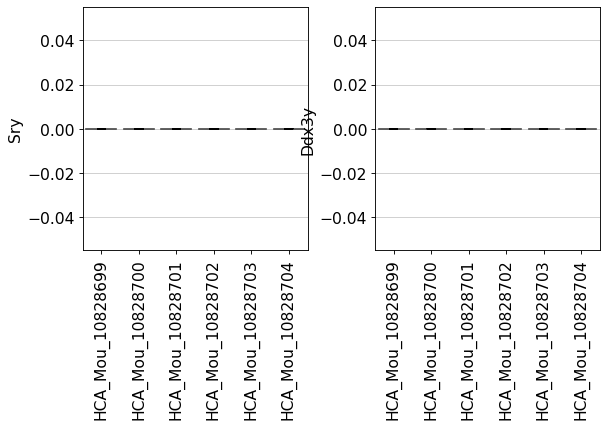

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


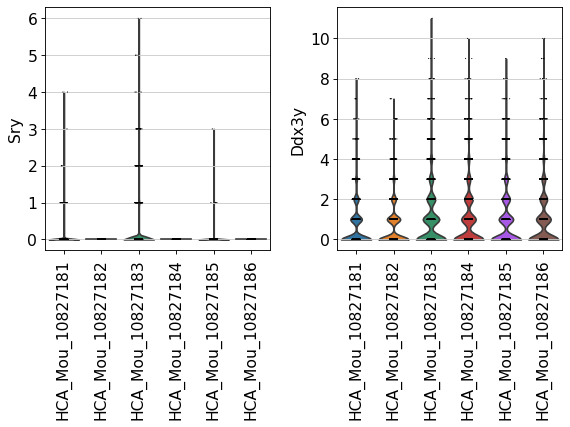

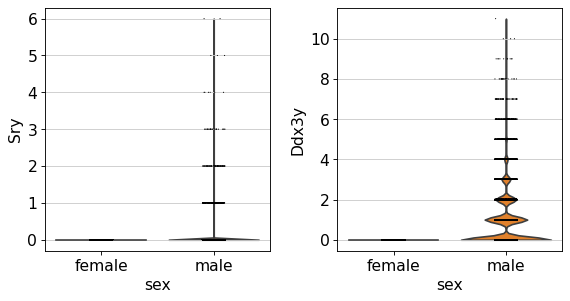

In [85]:
sc.pl.violin(adata[[ i == 'female' for i in adata.obs.sex]], ['Sry', 'Ddx3y'], groupby='sample', rotation = 90) # FEMALE
sc.pl.violin(adata[[ i == 'male' for i in adata.obs.sex]], ['Sry', 'Ddx3y'], groupby='sample', rotation = 90) # MALE
sc.pl.violin(adata, ['Sry', 'Ddx3y'], groupby='sex') # MALE

### Filter cells with few genes
Check number of genes per cell distribution and filter cells accordingly

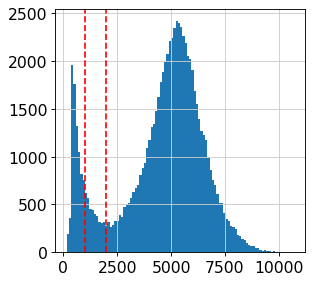

In [86]:
plt.hist(adata.obs['n_genes'], bins = 100)
plt.axvline(1000, linestyle = '--', color = 'red')
plt.axvline(2000, linestyle = '--', color = 'red')

In [87]:
sc.pp.filter_cells(adata, min_genes=2000)

filtered out 12158 cells that have less than 2000 genes expressed
/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [88]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
adata.obs['sample'].values.describe()

Total number of cells: 65389
Total number of genes: 24520


counts     freqs
categories                        
HCA_Mou_10827181    5599  0.085626
HCA_Mou_10827182    5390  0.082430
HCA_Mou_10827183    5933  0.090734
HCA_Mou_10827184    5065  0.077460
HCA_Mou_10827185    6073  0.092875
HCA_Mou_10827186    5218  0.079799
HCA_Mou_10828699    5677  0.086819
HCA_Mou_10828700    2886  0.044136
HCA_Mou_10828701    6756  0.103320
HCA_Mou_10828702    7689  0.117589
HCA_Mou_10828703    4561  0.069752
HCA_Mou_10828704    4542  0.069461


### Filter cells with large % mitochondrial genes

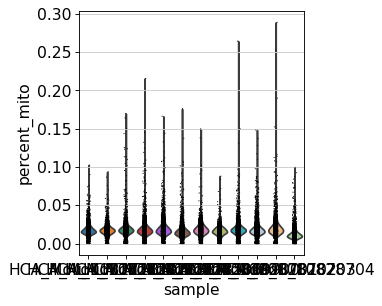

In [89]:
sc.pl.violin(adata, ['percent_mito'], groupby='sample') #hPGCs

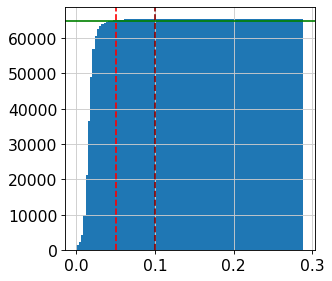

In [90]:
plt.hist(adata.obs['percent_mito'], bins = 100, cumulative=True)
plt.axvline(0.05, linestyle = '--', color = 'red')
plt.axvline(0.1, linestyle = '--', color = 'darkred')
plt.axhline(adata.n_obs*0.99, linestyle = '-', color = 'green')

In [91]:
# >5%
adata = adata[adata.obs['percent_mito'] < 0.05, :]

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [92]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
adata.obs['sample'].values.describe()

Total number of cells: 64879
Total number of genes: 24520


counts     freqs
categories                        
HCA_Mou_10827181    5575  0.085929
HCA_Mou_10827182    5378  0.082893
HCA_Mou_10827183    5890  0.090784
HCA_Mou_10827184    5005  0.077144
HCA_Mou_10827185    5995  0.092403
HCA_Mou_10827186    5174  0.079748
HCA_Mou_10828699    5661  0.087255
HCA_Mou_10828700    2878  0.044359
HCA_Mou_10828701    6702  0.103300
HCA_Mou_10828702    7615  0.117372
HCA_Mou_10828703    4484  0.069113
HCA_Mou_10828704    4522  0.069699

In [93]:
pd.DataFrame(adata.obs).to_csv(str(sc.settings.figdir)+'/metadata_filtered.csv')

### Filter genes expressed in less than 3 cells

In [94]:
sc.pp.filter_genes(adata, min_cells=3)

filtered out 38 genes that are detected in less than 3 cells
Trying to set attribute `.var` of view, copying.
/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [95]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))

Total number of cells: 64879
Total number of genes: 24482


### Identify cells behaving like cc genes
Per genes analysis: identify genes behaving like known cell cycle genes

In [96]:
bdata = adata.copy()
# Normalize total counts per cell
sc.pp.normalize_per_cell(bdata, counts_per_cell_after=1e4)
# Logarithmize the data matrix
sc.pp.log1p(bdata)

normalizing by total count per cell
    finished (0:00:03): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [97]:
# Extract highly variable genes
sc.pp.highly_variable_genes(bdata)
highly_variable_genes = bdata.var["highly_variable"]
bdata = bdata[:, highly_variable_genes]

extracting highly variable genes
    finished (0:00:06)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [98]:
# Traspose matrix for a GENE-centered analysis
bdata = bdata.copy().T

In [99]:
bdata.X.shape

(2828, 64879)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    with n_comps=50
    finished (0:00:26)


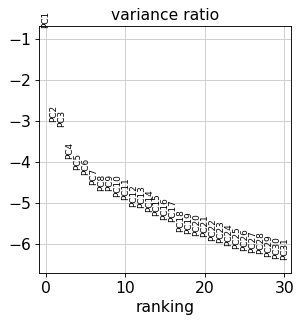

In [100]:
# Scale data to unit variance and zero mean
sc.pp.scale(bdata, max_value=10)

# Scatter plot in PCA coordinates
sc.tl.pca(bdata)
bdata.obsm['X_pca'] *= -1  # multiply by -1 to match Seurat
# Plot the variance ratio
sc.pl.pca_variance_ratio(bdata, log=True, save='_ccg_identification.pdf')

In [101]:
num_pcs = 20
# Compute a neighborhood graph of observations
sc.pp.neighbors(bdata, n_pcs=num_pcs)
# Embed the neighborhood graph using UMAP
sc.tl.umap(bdata)
# Cluster GENES into subgroups using louvain: resolution < 1 to find less clusters
sc.tl.louvain(bdata, resolution=1)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 14 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


... storing 'known_cyclers' as categorical


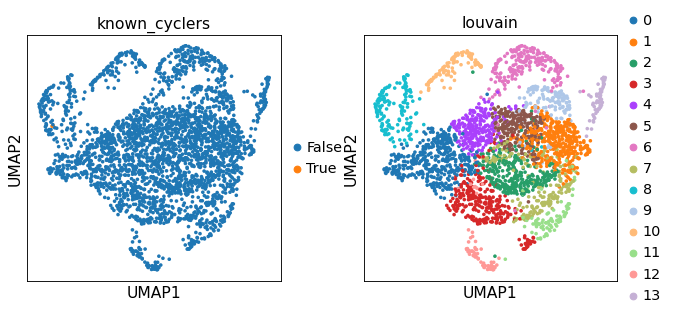

Cdk1     8
Mki67    8
Name: louvain, dtype: category
Categories (14, object): ['0', '1', '2', '3', ..., '10', '11', '12', '13']


In [102]:
# Locate ccs cluster
bdata.obs['known_cyclers'] = [i in ['Cdk1','Mki67'] for i in bdata.obs_names]
bdata.obs['known_cyclers'] = [ str(i) for i in  bdata.obs['known_cyclers']]
sc.pl.umap(bdata, color=['known_cyclers', 'louvain'], color_map='OrRd',save='_ccg_identification.pdf')
print(bdata.obs.loc[[i in ['Cdk1','Mki67'] for i in bdata.obs_names],'louvain'])

In [103]:
ccgs_cl = bdata.obs.loc['Cdk1',['louvain']][0]
print("Cell cycle genes cluster is "+ccgs_cl)

Cell cycle genes cluster is 8


### Flag ccgs

In [104]:
# Add unstructured dict-like annotation for ccgs
adata.uns['ccgs'] = list(bdata.obs[bdata.obs['louvain']==ccgs_cl].index)

In [105]:
# Move plots
MovePlots('ccg_identification','ccg_identification')

# Score cell cycle

In [106]:
s_genes = [x.strip() for x in open('/home/jovyan/utils/S_genes.tsv')]
g2m_genes = [x.strip() for x in open('/home/jovyan/utils/G2M_genes.tsv')]

s_genes = [ i.title() for i in s_genes]
g2m_genes = [i.title() for i in g2m_genes]

s_genes = [x for x in s_genes if x in adata.var_names]
g2m_genes = [x for x in g2m_genes if x in adata.var_names]

In [107]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
    finished: added
    'S_score', score of gene set (adata.obs).
    380 total control genes are used. (0:00:05)
computing score 'G2M_score'
/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
    finished: added
    'G2M_score', score of gene set (adata.obs).
    303 total control genes are used. (0:00:05)
-->     'phase', cell cycle phase (adata.obs)


## Identify HVGs

In [108]:
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=2000, subset=False)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


## Load scrublet

In [109]:
scorenames = ['scrublet_score','scrublet_cluster_score','zscore','bh_pval','bonf_pval']

scrdf = []
for sample in meta.index:
    scrdf.append(pd.read_csv('scrublet-scores/'+sample+'.csv', header=0, index_col=0))
scrdf = pd.concat(scrdf)
scrdf.index = [i.replace('-1', '') for i in scrdf.index]
for score in scorenames:
    adata.obs[score] = scrdf[score]
adata.obs['is_doublet'] = adata.obs['bonf_pval'] < 0.01

# Load previous annotations

In [110]:
meta_som.head()

scmap_fromHuman  \
Unnamed: 0                                          
HCA_Mou_10828699_AAACCTGAGATCACGG    CoelEpi_LHX9   
HCA_Mou_10828699_AAACCTGAGCCACCTG       preGC_IIa   
HCA_Mou_10828699_AAACCTGAGGCGTACA              Gi   
HCA_Mou_10828699_AAACCTGAGTGAAGTT              Gi   
HCA_Mou_10828699_AAACCTGAGTGTTGAA    CoelEpi_LHX9   

                                   scmap_similarities_fromHuman  
Unnamed: 0                                                       
HCA_Mou_10828699_AAACCTGAGATCACGG                      0.896478  
HCA_Mou_10828699_AAACCTGAGCCACCTG                      0.890231  
HCA_Mou_10828699_AAACCTGAGGCGTACA                      0.875119  
HCA_Mou_10828699_AAACCTGAGTGAAGTT                      0.899630  
HCA_Mou_10828699_AAACCTGAGTGTTGAA                      0.898240

In [111]:
# Add old cluster subname
meta_som = pd.read_csv('/nfs/team292/vl6/Mouse_Sanger/female_scmap_fromHuman.csv')
meta_som = meta_som.set_index('Unnamed: 0')
meta_som.head()

meta_germ = pd.read_csv('/nfs/team292/vl6/Mouse_Sanger/male_scmap_fromHuman.csv')
meta_germ = meta_germ.set_index('Unnamed: 0')
meta_germ.head()

cell_annot1 = meta_som['scmap_fromHuman'].to_dict()
cell_annot2 = meta_germ['scmap_fromHuman'].to_dict()
cell_annot = {**cell_annot1, **cell_annot2}
adata.obs['scmap_fromHuman'] = adata.obs_names.map(cell_annot)

In [112]:
# # Add old cluster subname
# meta_som = pd.read_csv('/nfs/team292/lg18/with_valentina/gonadsV2_revision/mouse_males_scVIintegrated_annotated.csv')
# meta_som = meta_som.set_index('Unnamed: 0')
# meta_som.head()

# meta_germ = pd.read_csv('/nfs/team292/lg18/with_valentina/gonadsV2_revision/mouse_females_scVIintegrated_annotated.csv')
# meta_germ = meta_germ.set_index('Unnamed: 0')
# meta_germ.head()

# cell_annot1 = meta_som['lineage'].to_dict()
# cell_annot2 = meta_germ['lineage'].to_dict()
# cell_annot = {**cell_annot1, **cell_annot2}
# adata.obs['lineage'] = adata.obs_names.map(cell_annot)

# Save raw counts

In [113]:
adata.write('/nfs/team292/lg18/with_valentina/gonadsV2_revision/mouse-gonads_rawcounts.h5ad')

... storing 'phase' as categorical
... storing 'scmap_fromHuman' as categorical
... storing 'lineage' as categorical


In [114]:
adata.raw = adata.copy()

# Normalize and do dim reduction

### Remove cc genes

In [115]:
adata = adata[:,[i not in adata.uns['ccgs'] for i in adata.var_names]]
print('Total number of genes after ccg filter: {:d}'.format(adata.n_vars))

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Total number of genes after ccg filter: 24331


### Normalize per cell and log transform

After removing unwanted cells and genes from the dataset, the next step is to normalize the data. 
By default, we employ a global-scaling normalization method “LogNormalize” that normalizes the feature expression measurements for each cell by the total expression, multiplies this by a scale factor (10,000 by default), and log-transforms the result. 

In [116]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

normalizing by total count per cell
Trying to set attribute `.obs` of view, copying.
    finished (0:00:12): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


### Filter HVGs in bdata and do PCA with them

In [117]:
bdata = adata[:, adata.var['highly_variable']]
print('Total number of cells: {:d}'.format(bdata.n_obs))
print('Total number of genes: {:d}'.format(bdata.n_vars))

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Total number of cells: 64879
Total number of genes: 1916


In [118]:
sc.pp.scale(bdata, max_value=10)
sc.tl.pca(bdata, svd_solver='arpack', n_comps=50)

/opt/conda/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:24)


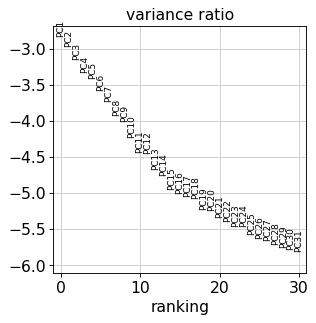

In [119]:
## Transfer PCA to the main adata
#fill NaNs with False so that subsetting to HVGs is possible
adata.var['highly_variable'].fillna(value=False, inplace=True)
adata.obsm['X_pca'] = bdata.obsm['X_pca'].copy()
adata.uns['pca'] = bdata.uns['pca'].copy()
adata.varm['PCs'] = np.zeros(shape=(adata.n_vars, 50))
adata.varm['PCs'][adata.var['highly_variable']] = bdata.varm['PCs']
sc.pl.pca_variance_ratio(adata, log=True, save='.pdf')

### UMAP

In [120]:
n_pcs = 21

sc.pp.neighbors(adata, n_pcs = n_pcs)
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 21
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:20)


# Save processed

In [121]:
adata.write('mouse-M1processed.h5ad')

# Visualize data

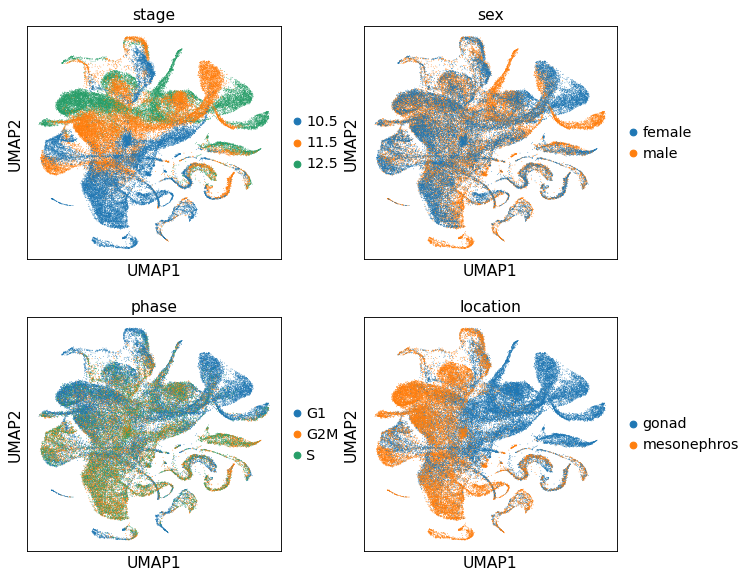

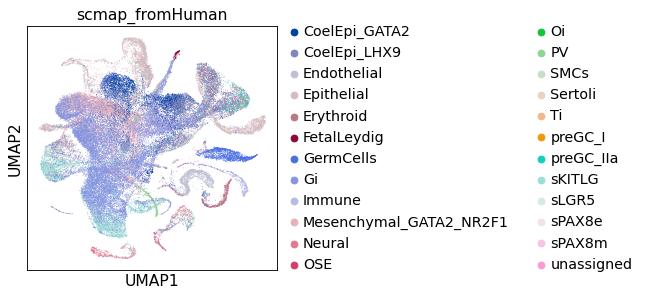

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


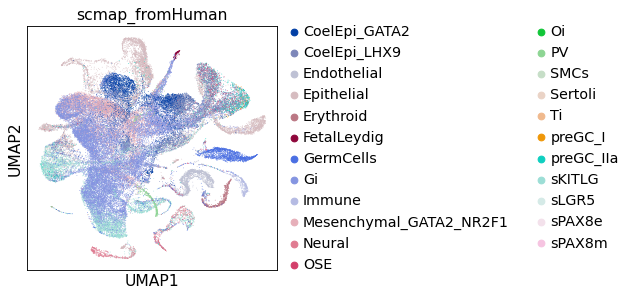

Trying to set attribute `.uns` of view, copying.


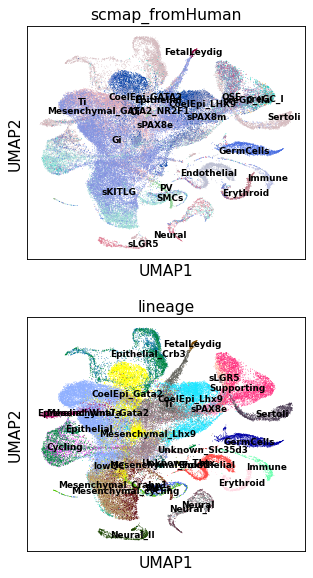

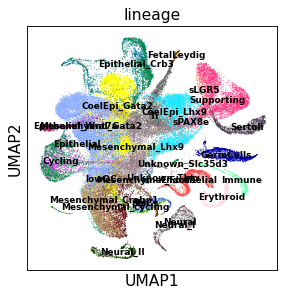

In [122]:
sc.pl.umap(adata, color=['stage','sex','phase','location'], ncols = 2)
sc.pl.umap(adata, color=['scmap_fromHuman'])
sc.pl.umap(adata[[i not in ['unassigned', 'nan'] for i in adata.obs.scmap_fromHuman]], color=['scmap_fromHuman'])
sc.pl.umap(adata[[i not in ['unassigned', 'nan'] for i in adata.obs.scmap_fromHuman]], color=['scmap_fromHuman', 'lineage'], legend_loc='on data', legend_fontsize=8, ncols=1)
sc.pl.umap(adata, color=['lineage'], legend_loc='on data', legend_fontsize=8, ncols=1)

# Plot markers

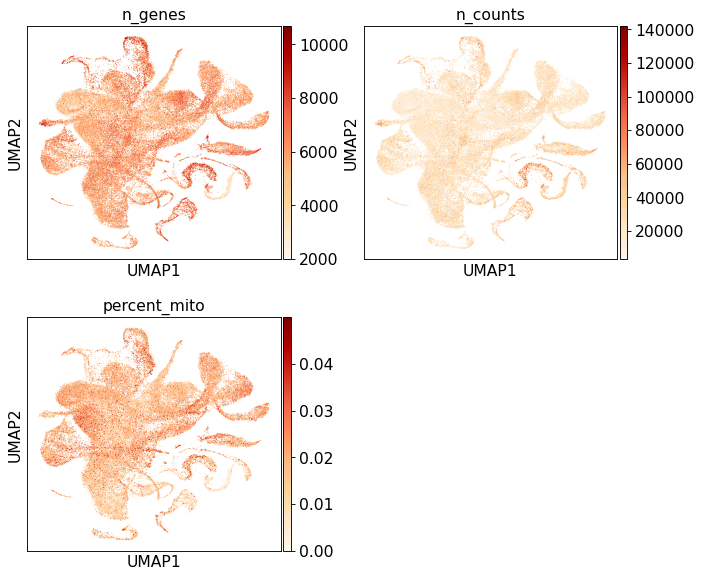

In [123]:
sc.pl.umap(adata, color=['n_genes','n_counts',  'percent_mito'], save='_predoublet_stats.pdf', ncols = 2, color_map='OrRd', use_raw=False)

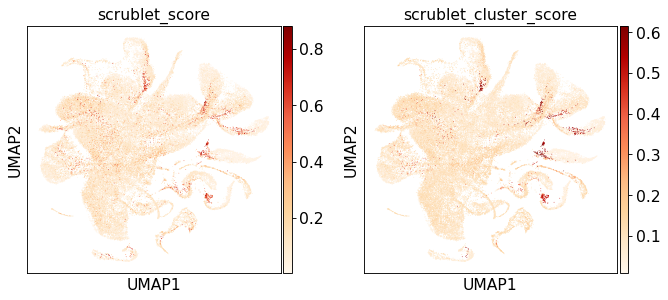

In [124]:
sc.pl.umap(adata, color=['scrublet_score', 'scrublet_cluster_score'], color_map='OrRd')

In [125]:
sc.pp.scale(adata, max_value=10, copy=True)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


AnnData object with n_obs × n_vars = 64879 × 24331
    obs: 'n_genes', 'sample', 'stage', 'sex', 'location', 'percent_mito', 'n_counts', 'batch', 'S_score', 'G2M_score', 'phase', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet', 'scmap_fromHuman', 'lineage'
    var: 'gene_ids-0', 'feature_types-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'n_cells-11', 'gene_ids-2', 'feature_types-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'n_cells-6', 'gene_ids-7', 'feature_types-7', 'n_cells-7', 'gene_ids-8', 'feature_types-8', 'n_cells-8', 'gene_ids-9', 'feature_types-9', 'n_cells-9', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'sample_colors',

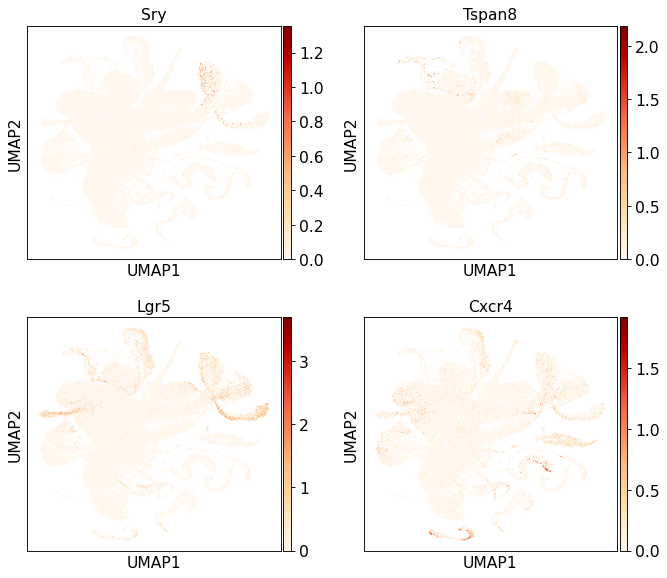

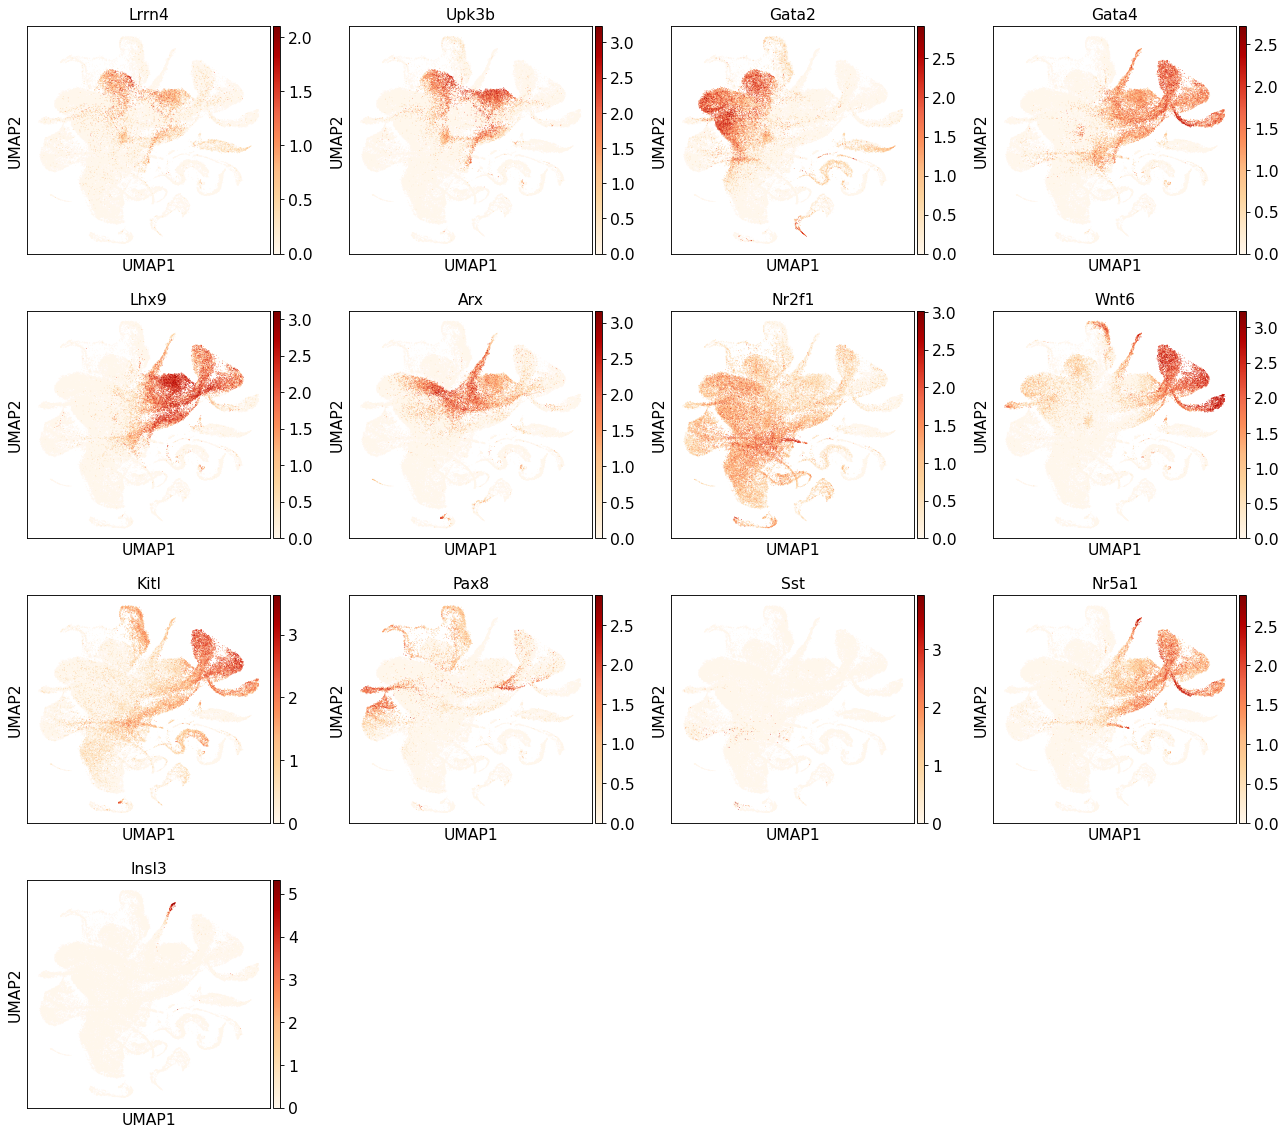

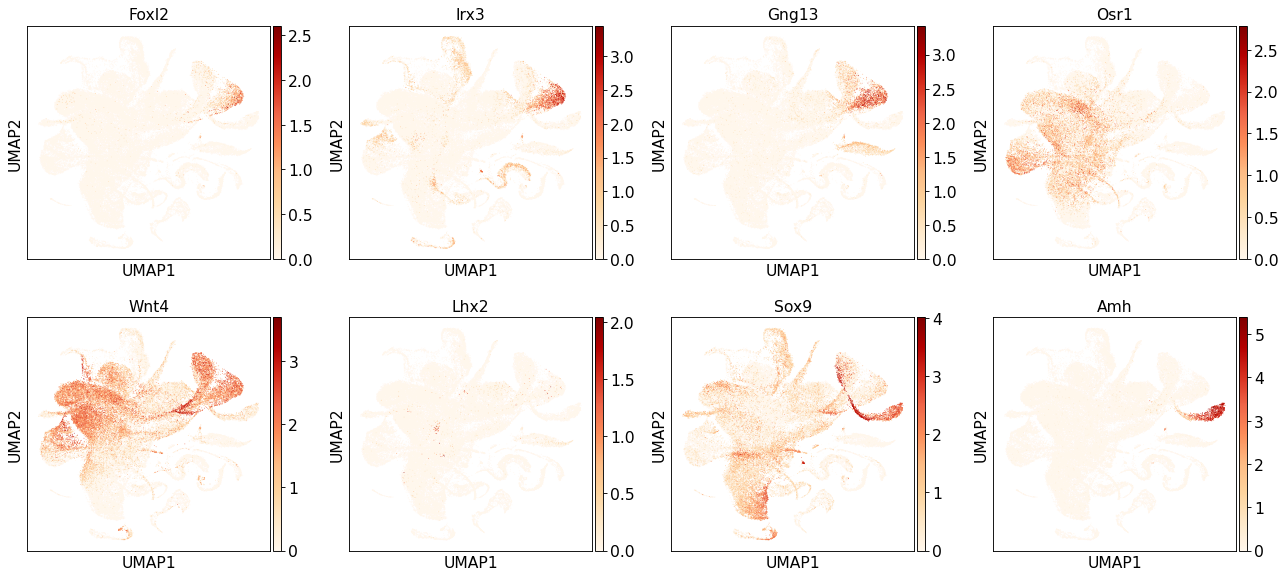

In [126]:

sc.pl.umap(adata, color=['Sry', 'Tspan8', 'Lgr5', 'Cxcr4'], save='_predoublet_markers.pdf', ncols = 2, color_map='OrRd', use_raw=False)
sc.pl.umap(adata, color=['Lrrn4', 'Upk3b', "Gata2", "Gata4", "Lhx9", "Arx", "Nr2f1", 'Wnt6', 'Kitl', 'Pax8', 'Sst' , 'Nr5a1', 'Insl3'], save='_predoublet-markers_global.pdf',color_map='OrRd', use_raw=False)
sc.pl.umap(adata, color=['Foxl2', 'Irx3', 'Gng13', 'Osr1', 'Wnt4', 'Lhx2', 'Sox9', 'Amh'], save='_predoublet-markers_global.pdf',color_map='OrRd', use_raw=False)


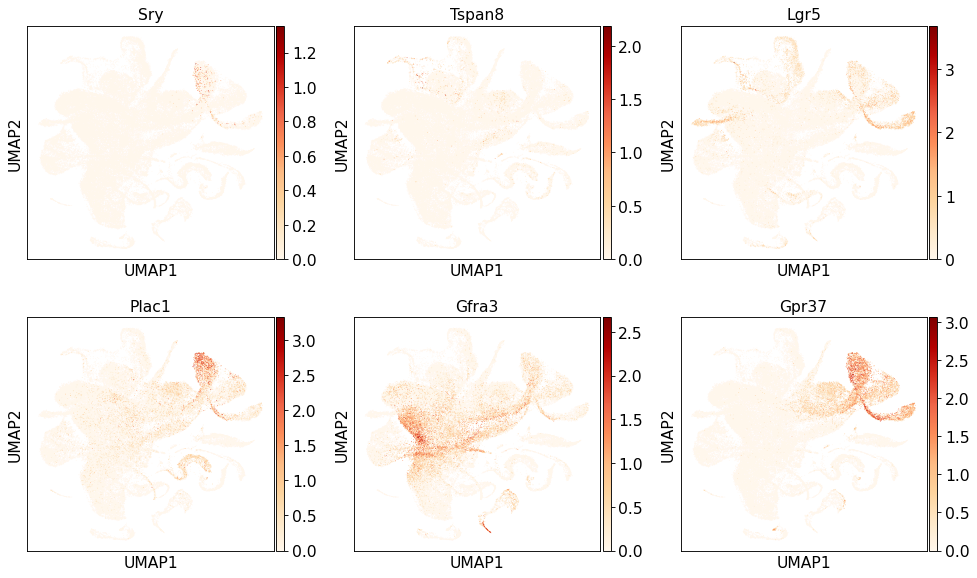

In [127]:
# GFRA3
# BX470209.1
# PLAC1
# CCDC73
# NPY
# APOBEC3C
# GRID2
# AC022075.1
# SRY
# AC112487.1
# AMOT
# HMGA2
# APCDD1L
# HRASLS
# IGF2BP1
# MME
# STRA6
# GPR37
# GLUD2
# DPP10
# TAC1
# ABCA9-AS1
# BX470209.1
# REG3G
# HRASLS
# GFRA3
# ACTC1
# TSPAN8
# SYNDIG1
# BIK
# ZPBP
# TMEM59L
# APOBEC3H
# MME
# CPVL
# AP002884.1
# CCDC73
# APCDD1L
# ANOS1
# TDGF1
sc.pl.umap(adata, color=['Sry', 'Tspan8', 'Lgr5', 'Plac1', "Gfra3",'Gpr37'], color_map='OrRd', use_raw=False, ncols=3 )

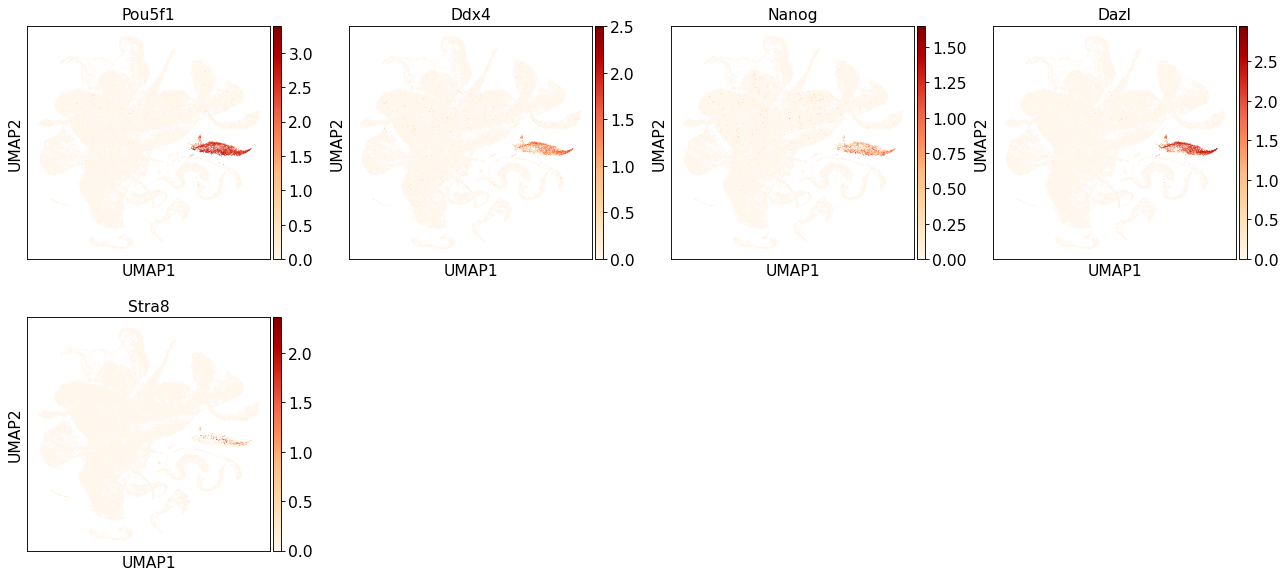

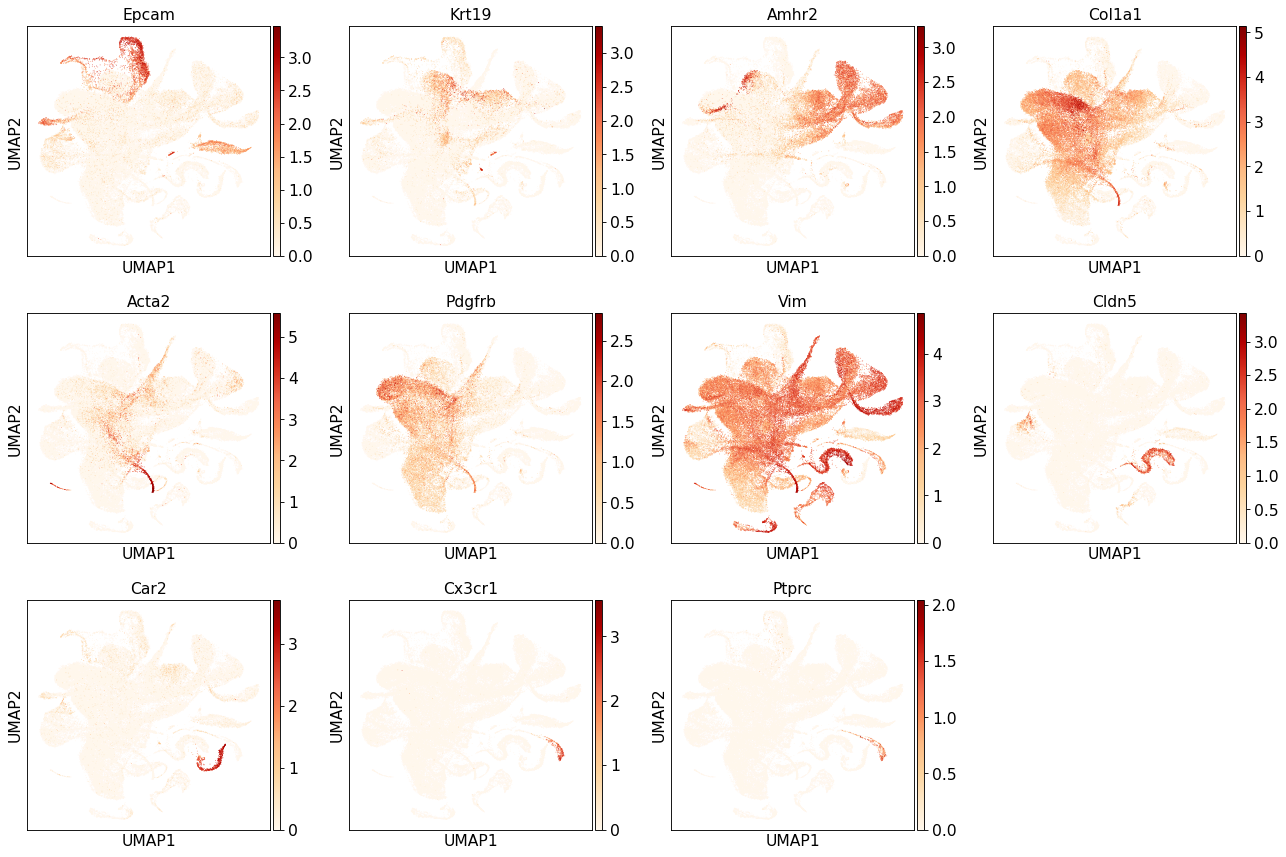

In [128]:
sc.pl.umap(adata, color=["Pou5f1", "Ddx4", 'Nanog', 'Dazl', 'Stra8'],color_map='OrRd', use_raw=False)
sc.pl.umap(adata, color=['Epcam', 'Krt19', 'Amhr2','Col1a1', 'Acta2', 'Pdgfrb', 'Vim', 'Cldn5', 'Car2', 'Cx3cr1', 'Ptprc'], color_map='OrRd', use_raw=False )